### 1. Generate two finite sequences of length 5 and 4

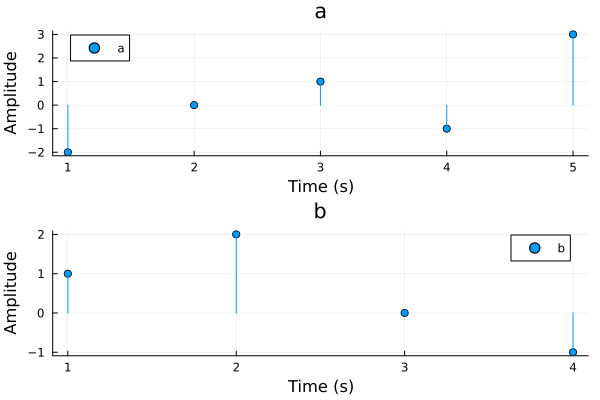

In [1]:
using Plots
a = [-2, 0, 1, -1, 3]
b = [1, 2, 0, -1]
a_t = 1:1:length(a)
b_t = 1:1:length(b)

layout = (2, 1)

p1 = plot(a_t, a, line=:stem, marker=:circle, label="a", title="a")
p2 = plot(b_t, b, line=:stem, marker=:circle, label="b", title="b")
plot(p1, p2, layout=layout, ylabel="Amplitude", xlabel="Time (s)")

### 2. Convolute the two sequences

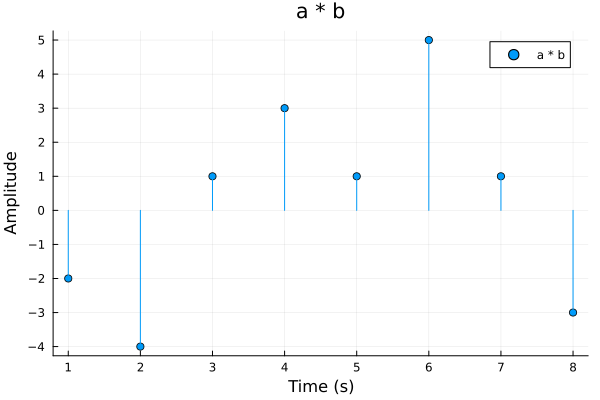

In [2]:
using DSP

convolution_result = conv(a, b)
plot(convolution_result, label="a * b", title="a * b", ylabel="Amplitude", xlabel="Time (s)",
    line=:stem, marker=:circle,
    xticks=1:1:length(convolution_result),
    yticks=range(min(convolution_result...), max(convolution_result...)))

### 3. Perform the Fourier Transform on each sequence, then plot the transformed signals multiplied together

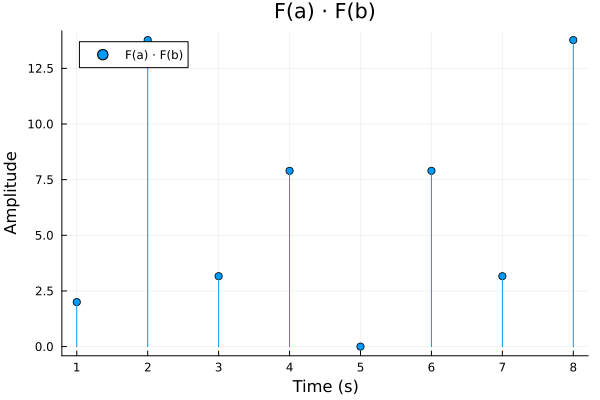

In [3]:
import FFTW.fft, FFTW.ifft

# fill with zeros if the length of the vector is less than lenb
fft(vector::Vector, len::Int) = fft(vcat(vector, zeros(len - length(vector))))

convolution_length = length(a) + length(b) - 1
a_fft = fft(a, convolution_length)
b_fft = fft(b, convolution_length)
a_fft_times_b_fft = a_fft .* b_fft
plot(abs.(a_fft_times_b_fft), label="F(a) · F(b)", title="F(a) · F(b)", ylabel="Amplitude", xlabel="Time (s)",
    line=:stem, marker=:circle,
    xticks=1:1:length(a_fft_times_b_fft))

### 4. By the Convolution Theorem, the convolution of two sequences is equivalent to the multiplication. Perform the inverse Fourier Transform on the product of the two transformed signals to obtain the convolution of the two sequences and plot the result.

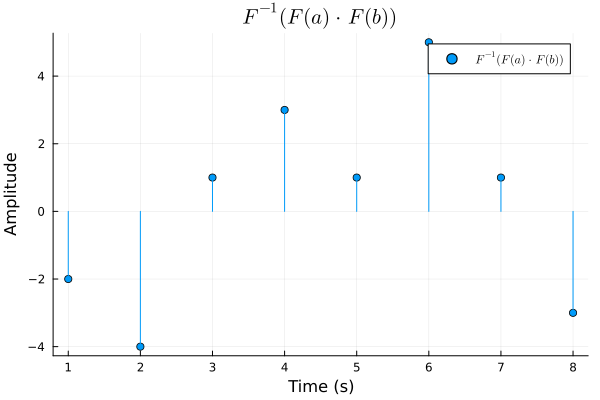

In [4]:
using LaTeXStrings

ifft_convolution = real.(ifft(a_fft_times_b_fft))

label = L"F^{-1}(F(a) \cdot F(b))"
plot(ifft_convolution, label=label, title=label, ylabel="Amplitude", xlabel="Time (s)",
    line=:stem, marker=:circle,
    xticks=1:1:length(a_fft_times_b_fft))

### 5. Compare the result with the actual convolution by calculating the error and plotting the results.

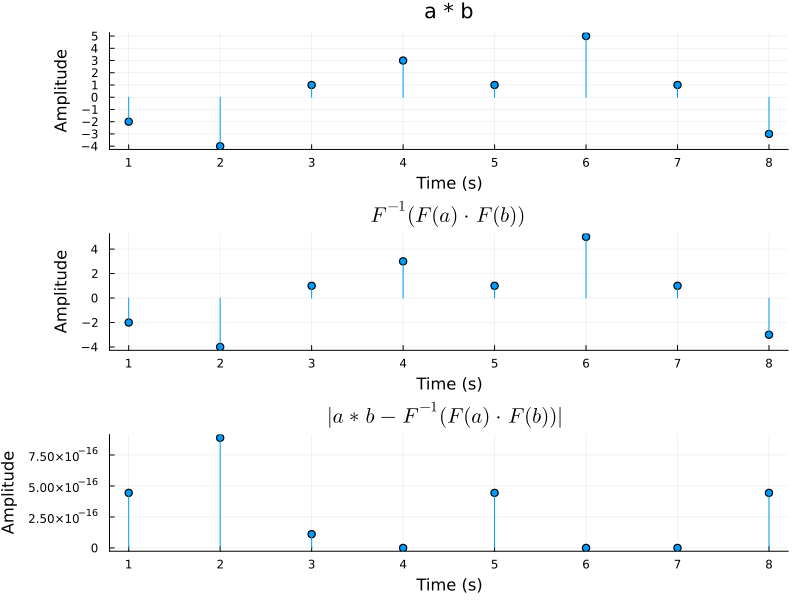

In [5]:
abs_error = abs.(convolution_result .- ifft_convolution)

layout = (3, 1)

p1 = plot(convolution_result, title="a * b", ylabel="Amplitude", xlabel="Time (s)",
    line=:stem, marker=:circle,
    xticks=1:1:length(convolution_result),
    yticks=range(min(convolution_result...), max(convolution_result...)))
p2 = plot(ifft_convolution, title=L"F^{-1}(F(a) \cdot F(b))", ylabel="Amplitude", xlabel="Time (s)",
    line=:stem, marker=:circle,
    xticks=1:1:length(ifft_convolution))
p3 = plot(abs_error, title=L"|a * b - F^{-1}(F(a) \cdot F(b))|", ylabel="Amplitude", xlabel="Time (s)",
    line=:stem, marker=:circle,
    xticks=1:1:length(abs_error))

plot(p1, p2, p3, layout=layout, legend=false, size=(800, 600))

Based on the results, the "errors" that have been calculated are in the order of 10<sup>-16</sup>, which is due to the numerical precision of the calculations on a 64 bit processor. Therefore, the results are consistent with the Convolution Theorem.

### 6. Repeat the steps 1-5 with different sequences that is much bigger in size to see the performance of performing the convolution using the Convolution Theorem and FFT.

#### 6.1. Generate the sequences using some well-known periodic functions such as sine, cosine, square, and sawtooth waves.

In [15]:
using Waveforms

len = 2^16

long_a = cos.(0:len)
long_b = squarewave.(0:len);

#### 6.1, 6.2. Measure the time taken to perform the convolution directly and using the Convolution Theorem and FFT.

In [16]:
function fft_conv(a::Vector{T}, b::Vector{T}) where {T<:Number}
    a_fft = fft(a, length(a) + length(b) - 1)
    b_fft = fft(b, length(a) + length(b) - 1)
    a_fft_times_b_fft = a_fft .* b_fft
    real.(ifft(a_fft_times_b_fft))
end

@time conv(long_a, long_b)
@time fft_conv(long_a, long_b);

  0.010745 seconds (23 allocations: 5.006 MiB)
  0.099047 seconds (8.26 k allocations: 16.540 MiB, 70.76% compilation time)


From the results it might seem that the Convolution Theorem and FFT is slower than the direct convolution. The reason is that the library used, DSP, in Julia, already uses the convolution theorem and FFT to perform the convolution. Furthermore, it appears to be faster, probably due to optimisations of not allocating memory for the transformed signals and doing vectorised operations. To get the desired comparison, I will implement a convolution function based on the mathematical definition.

In [17]:
function my_conv(a::Vector{T}, b::Vector{T}) where {T<:Number}
    m = length(a)
    n = length(b)
    w = zeros(m + n - 1)
    # optimization using @inbounds
    @inbounds begin
        for j in 1:m, k in 1:n
            w[j+k-1] += a[j] * b[k]
        end;
    end
    return w
end

@time my_conv(long_a, long_b)
@time fft_conv(long_a, long_b);

  0.763074 seconds (6.50 k allocations: 1.434 MiB, 2.22% compilation time)
  0.031554 seconds (34 allocations: 16.002 MiB)


### 7. Repeat the time comparison in point 6 with bigger length sequences. For example 2<sup>17</sup>, 2<sup>18</sup>, 2<sup>19</sup>.

In [18]:
lengths = [2^17, 2^18, 2^19]
for len in lengths
    a = cos.(0:len)
    b = squarewave.(0:len)
    println("length = $len")
    println("convolution")
    @time my_conv(a, b)
    println("fft convolution")
    @time fft_conv(a, b)
end

length = 131072
convolution
  5.037291 seconds (2 allocations: 2.000 MiB)
fft convolution
  0.052494 seconds (34 allocations: 32.002 MiB, 12.73% gc time)
length = 262144
convolution
 20.535081 seconds (2 allocations: 4.000 MiB)
fft convolution
  0.150812 seconds (34 allocations: 64.002 MiB, 1.67% gc time)
length = 524288
convolution
 85.245784 seconds (2 allocations: 8.000 MiB, 0.02% gc time)
fft convolution
  0.479755 seconds (34 allocations: 128.002 MiB, 54.57% gc time)


The comparison between the O(n<sup>2</sup>) and O(n log n) algorithms is more evident with bigger sequences.

### 8. The mentioned method performs the convolution of two signals integrally. In some applications, it is necessary to perform the convolution of the signal as it is formed or measured. In this case, block convolution is performed, in which the signal is divided into blocks and convolution is performed on blocks. Let us have two signals of the type of an input signal and the second - the system response to the unit impulse. Determine the convolution of the signals:

```julia
a=[1, 2, 3, 4, 5, 4, 3, 3, 2, 2, 1, 1]
b=[1, 4, 2]
```

In [48]:
a=[1, 2, 3, 4, 5, 4, 3, 3, 2, 2, 1, 1]
b=[1, 4, 2]

println(conv(a, b))

[1, 6, 13, 20, 27, 32, 29, 23, 20, 16, 13, 9, 6, 2]


### 9. Divide the signal into blocks of half the size of signal an convolve the blocks saparetely.

In [49]:
a1 = a[1:div(end, 2)]
a2 = a[div(end, 2)+1:end]
block1 = conv(a1, b)
block2 = conv(a2, b)
println("Block 1: $block1")
println("Block 2: $block2")

Block 1: [1, 6, 13, 20, 27, 32, 26, 8]
Block 2: [3, 15, 20, 16, 13, 9, 6, 2]


### 10. Determine the final convolution of the blocks combined.

In [51]:
combined_blocks = zeros(length(block1) + length(block2) - 2)
combined_blocks[1:length(block1)] = block1
combined_blocks[length(block1)-1:end] += block2
println("Combined blocks:\t$(convert(Vector{Int64},combined_blocks))")
println("Direct convolution:\t$(conv(a, b))")

Combined blocks:	[1, 6, 13, 20, 27, 32, 29, 23, 20, 16, 13, 9, 6, 2]
Direct convolution:	[1, 6, 13, 20, 27, 32, 29, 23, 20, 16, 13, 9, 6, 2]
